In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import jax.random as jr
import tensorflow_probability as tfp
from jax import numpy as jnp, random as jr
from sbijax import NPE
from sbijax.nn import make_maf, make_mdn
from tensorflow_probability.substrates.jax import distributions as tfd

from sbijax import plot_posterior, plot_trace, plot_rank, plot_rhat_and_ress
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import matplotlib as mpl
mpl.rcParams.update({"text.usetex": False,
                     })#mpl.rcParamsDefault)

mpl.rcParams.update(mpl.rcParamsDefault)

%load_ext autoreload
%autoreload 2

gpu


2025-02-04 23:43:42.822125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-04 23:43:42.822211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-04 23:43:42.854651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 23:43:51.448091: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
jnp.ones((2,))

2025-02-04 23:44:26.121637: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.0 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Array([1., 1.], dtype=float32)

In [3]:
pwd

'/home/makinen/repositories/des-hybrid/vanilla-comparison'

In [4]:
cd /home/makinen/repositories/des-hybrid

/home/makinen/repositories/des-hybrid


/home/makinen/venvs/epe/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# des tfrecords loader code

In [5]:
import glob
import os

import tensorflow as tf
import tensorflow_datasets as tfds


base_path = "/data103/makinen/des_sims/Gower_street_SBI_tfrecords/"
patch = "A"
use_noise_realisations =['0','1','2','3','10', '11', '12']#,'11','12','13','14','15']
cls_stats_file = np.load("/home/makinen/repositories/des-hybrid/cls_utils/cls_statistics_for_normalisation.npz")
S1_cls=cls_stats_file["S1_cls"]
S2_cls=cls_stats_file["S2_cls"]
mean_cl=cls_stats_file["mean_cl"]
std_cl=cls_stats_file["std_cl"]
cut_idx=cls_stats_file["cut_idx"]


def gaussian_noise_augmentation(x, y, cls):
    x += tf.random.normal(
                        shape = [512, 512,8],
                        mean = 0,
                        stddev = 1e-3,
                        dtype = tf.float32
                        ) #Mask option?

    # add noise to cls
    cls += tf.random.normal(
                shape = [10, 2, 4, 28],
                mean = 0, 
                stddev =std_cl*1e-3,
                dtype = tf.float32
                )

    # data is now a dictionary
    return {"y": {"kappa": x, "cls": cls}, "theta": y}



def ret_scaled_param(data,param):
    s = 0.6
    if param == 'AIA':
        hi = 3
        lo = -3

    if param == "s8":
        hi = 1.32
        lo = 0.4

    if param == 'om':
        hi = 0.5
        lo = 0.13

    if param == "h":
        hi = 0.6
        lo = 0.8

    if param == 'w':
        hi = -0.33
        lo = -1.8
    if param == "ns":
        hi = 0.99
        lo = 0.94
    if param == 'ob':
        hi = 0.061
        lo = 0.037


    return (data[param] -lo)*s/(hi - lo) + (1 - s)*0.5

def param_proc(data, scale_params=True):
    Y = []
    for p in sel_params:
        # scale params if so desired
        if scale_params:
            if p=="S8":
                Y.append(data["s8"]*tf.math.sqrt(data["om"]/0.3)-0.25)
            else:
                Y.append(ret_scaled_param(data, p))
                
        # else just return the param
        else:
            Y.append(data[p])
            
    Y = tf.convert_to_tensor( Y , dtype = tf.float32)
    return Y

def cls_proc(data):
    Cls = []
    for c in cl_modes:

        cls = tf.io.parse_tensor(data[c], out_type=tf.float32)
        cls = tf.cast(cls, tf.float32)
        
        Cls.append(cls)
    
    return Cls #tf.convert_to_tensor(Cls, dtype=tf.float32)

def return_train_test_lists(patch):
    files = glob.glob(base_path + "{}/".format(patch) +"shear_maps_*")
    print(base_path + "{}/".format(patch) +"shear_maps_*")
    print(len(files))
    train_file_list = []
    test_file_list = []
    lfi_file_list = []
    test_file_systematic_list = []
    for file in files:
        noiserel = file.split("_rel")[0].split('noiserel')[-1]
        if noiserel in use_noise_realisations:
            if noiserel == '3':
                test_file_list.append(file)
            elif noiserel == '10':
                lfi_file_list.append(file)
            elif noiserel == '12':
                test_file_systematic_list.append(file)
            else:
                train_file_list.append(file)
    return train_file_list, test_file_list, lfi_file_list, test_file_systematic_list

def parse_serialized_file(cereal_yum, scale_params=True, filter_w=True):

    features = {
            "kappa_patch":  tf.io.FixedLenFeature([], tf.string),
            #"CLS":  tf.io.FixedLenFeature([], tf.float32, default_value=0.0),

            # load the cls values
            "1_1": tf.io.FixedLenFeature([], tf.string),
            "1_2": tf.io.FixedLenFeature([], tf.string),
            "1_3": tf.io.FixedLenFeature([], tf.string),
            "1_4": tf.io.FixedLenFeature([], tf.string),
            "2_2": tf.io.FixedLenFeature([], tf.string),
            "2_3": tf.io.FixedLenFeature([], tf.string),
            "2_4": tf.io.FixedLenFeature([], tf.string),
            "3_3": tf.io.FixedLenFeature([], tf.string),
            "3_4": tf.io.FixedLenFeature([], tf.string),
            "4_4": tf.io.FixedLenFeature([], tf.string),

            # load parameters
            "s8": tf.io.FixedLenFeature([], tf.float32),
            "om": tf.io.FixedLenFeature([], tf.float32),
            "AIA": tf.io.FixedLenFeature([], tf.float32),
            "w": tf.io.FixedLenFeature([], tf.float32)
    }

    data = tf.io.parse_single_example(cereal_yum, features)

    # filter out w < -1
    # dummyY = param_proc(data, scale_params=False)
    # if filter_w:
    #     if dummyY[2] < -1:
    #         pass
            
    #     else:
    #         # process params and Cls
    #         Y = param_proc(data, scale_params=scale_params)
    #         CLS_DS = cls_proc(data)
        
    #         X_DS = tf.io.parse_tensor(data["kappa_patch"], out_type=tf.float32)
    #         X_DS = tf.cast(X_DS, tf.float32)
    #         X_DS = tf.reshape(X_DS, shape=(8,512,512))
    #         X_DS = tf.transpose(X_DS, perm = [1,2,0])
        
    #         return X_DS,Y,CLS_DS

    # else:
    # proceed as usual to get everything
    Y = param_proc(data, scale_params=scale_params)
    CLS_DS = cls_proc(data)

    X_DS = tf.io.parse_tensor(data["kappa_patch"], out_type=tf.float32)
    X_DS = tf.cast(X_DS, tf.float32)
    X_DS = tf.reshape(X_DS, shape=(8,512,512))
    X_DS = tf.transpose(X_DS, perm = [1,2,0])
    
    return X_DS,Y,CLS_DS





def get_single_param(data, param_idx=0):
    return {"y": {"kappa": data["y"]["kappa"], "cls": data["y"]["cls"]}, "theta": data["theta"][:, param_idx][:, np.newaxis]}
    

#train_dataset_single = train_dataset.map(lambda d: get_single_param(d),num_parallel_calls=tf.data.AUTOTUNE)



with tf.device("CPU"):
    sel_params = ["om","s8","w"]
    cl_modes = ["1_1","1_2","1_3","1_4","2_2","2_3","2_4","3_3","3_4", "4_4"]
    BATCH_SIZE = 64
    EPOCHS = 1000 # max epochs
    n_readers=1
    try:
        del train_dataset
        del test_dataset
        gc.collect()
    except:
        pass        

    SHUFFLE_BUFFER_SIZE = 100
    train_files, test_files, lfi_files, test_sys_files = return_train_test_lists('{}'.format(patch))
    num_train_files = len(train_files)
    num_test_files = len(test_files)
    num_lfi_files = len(lfi_files)
    num_sys_files = len(test_sys_files)

    print("train files: ", num_train_files, "test files: ", num_test_files, "lfi files: ", num_lfi_files, "test sys files: ", num_sys_files,)


    def get_tfdataset(files, 
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS,
                          scale_params=True, 
                          param_idx=None,
                          to_numpy=True,
                          shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
                          drop_remainder=True):
        
        num_files = len(files)
        print("num files: ", num_files)
        tfdataset = tf.data.Dataset.from_tensor_slices(files)
        
        tfdataset = tfdataset.interleave(
            tf.data.TFRecordDataset,
            cycle_length=n_readers,
            block_length=1,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True,
        )

        tfdataset = tfdataset.map(
            lambda serialized_example: parse_serialized_file(
                serialized_example,
                scale_params=scale_params    
            ),
            num_parallel_calls=tf.data.AUTOTUNE,
        )

        tfdataset = tfdataset.shuffle(shuffle_buffer_size)
        tfdataset = tfdataset.map(lambda maps,vals,cls: \
                                  gaussian_noise_augmentation(maps,vals,cls),num_parallel_calls=tf.data.AUTOTUNE)
        tfdataset = tfdataset.batch(batch_size, drop_remainder=drop_remainder).prefetch(tf.data.AUTOTUNE) 
        tfdataset = tfdataset.repeat(epochs)
        
        if param_idx is not None:
            print("retrieving parameter %d"%(param_idx))
            tfdataset = tfdataset.map(lambda d: get_single_param(d, param_idx=param_idx),num_parallel_calls=tf.data.AUTOTUNE)

        if to_numpy:
            tfdataset = tfdataset.as_numpy_iterator()
            tfdataset.num_batch_per_epoch = num_files // batch_size
            tfdataset.num_samples = (num_files // batch_size) * batch_size


        return tfdataset
        

    # train, test validation datasets
    train_dataset = get_tfdataset(train_files, BATCH_SIZE, scale_params=True, to_numpy=True)
    
    test_dataset = get_tfdataset(test_files, BATCH_SIZE, scale_params=True, to_numpy=True)

    lfi_dataset = get_tfdataset(lfi_files, BATCH_SIZE, scale_params=False, to_numpy=True, epochs=5, drop_remainder=False)
    sys_dataset = get_tfdataset(test_sys_files, BATCH_SIZE, scale_params=False, to_numpy=True, epochs=5, drop_remainder=False)

    

/data103/makinen/des_sims/Gower_street_SBI_tfrecords/A/shear_maps_*
30880
train files:  12352 test files:  3088 lfi files:  3088 test sys files:  3088
num files:  12352
num files:  3088
num files:  3088
num files:  3088


In [6]:
train_dataset.num_samples, train_dataset.num_batch_per_epoch, 

(12352, 193)

## config stuff

In [9]:
#@title config code
import sys,os
import yaml
import jax_cosmo as jc

from network.cls_utils import *
from network.net_utils import *
from network.new_epe_code import *


import sys,os
import yaml
import numpy as np
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


# -----
# folder to load config file
CONFIG_PATH = "./network/"

config_name = "config_default.yaml"
noiseamp = 0.125

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

config = load_config(config_name)
# -----

num_tomo = 4
indices = jnp.array(indices_vector(config["num_tomo"]))
# define the mpk layer before initialising network
dtype = jnp.float32 # jnp.bfloat16
kernel_size = config["mpk_kernel"]
polynomial_degrees = config["polynomial_degrees"]
mpk_layer = MultipoleCNNFactory(
            kernel_shape=(kernel_size, kernel_size),
            polynomial_degrees=polynomial_degrees,
            output_filters=None,
            dtype=dtype)



In [23]:
# load model code
from network.new_epe_code import *

def slice_cls(cls):
    cls = (cls - mean_cl) / std_cl
    cls = cls[:, :, 0, 0::3, :cut_idx]
    return cls.reshape(cls.shape[0], -1)

def slice_cls_single(cls):
    cls = (cls - mean_cl) / std_cl
    cls = cls[:, 0, 0::3, :cut_idx]
    return cls.reshape(cls.shape[0], -1)

# define model trained previously

class Cls_MLP_Network(nn.Module):
    hidden_channels: list
    n_summaries: int
    act: Callable = nn.relu
    sigmoid_out: bool = False

    def setup(self):
        self.embed = nn.Dense(450)
        self.embed2 = nn.Dense(500)
        #self.layernorm = nn.LayerNorm()
        self.net = MLP(self.hidden_channels + (self.n_summaries,), act=self.act)

    def __call__(self, x):

        # cut down mass value
        x = slice_cls_single(x)
        x = x.reshape(-1)
        x = self.embed(x)
        # x = self.layernorm(x)
        #x = self.embed2(x)
        x = self.act(x)
        x = self.net(x)

        if self.sigmoid_out:
            x = nn.sigmoid(x)

        return x

class ClsModel(EPEModel, nn.Module):
    n_summaries: int
    n_params: int = 3
    n_components: int = 4

    def setup(self):
        self.mdn = MDN(
                        hidden_channels=[100],
                        n_components=self.n_components,
                        n_dimension=self.n_params,
                        act=nn.relu)
        
        self.mlp = Cls_MLP_Network(
                        hidden_channels=[256]*10,
                        n_summaries=self.n_summaries,
                        act=smooth_leaky,
                        sigmoid_out=False)

    def get_embed(self, x):
        return self.mlp(x)

    def log_prob(self, x, theta):
        x = self.mlp(x)
        return self.mdn(x, theta) 

    #@nn.compact
    
    def __call__(self, x, theta):
        x = self.mlp(x)
        #return x
        return self.mdn(x, theta)



key = jax.random.PRNGKey(0) # pseudo-random key for Jax network.
cls_model = ClsModel(n_summaries=10)

cls_single_shape = (10, 2, 4, 28,)
w_cls_compress = load_obj("/data103/makinen/des_results/cls_net/w_cls_compress_mdn_10summaries.pkl")

cls_compression = lambda d: cls_model.apply(w_cls_compress, d, method=cls_model.get_embed)

In [24]:
class simpleCNN(nn.Module):
    """An incept-stride net architecture with MultiPole Kernel (MPK) embedding"""
    filters: Sequence[int]
    cls_compression: Callable
    n_extra: int = 3
    act_cnn: Callable = nn.relu
    act_dense: Callable = nn.swish
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x, return_embed=False):

        filters = self.filters
        # add in Cls information
        cls_summs = x["cls"]
        cls_summs = self.cls_compression(cls_summs)
        
        x = x["kappa"]

        x = x.astype(self.dtype)
        for i in range(8):
            x = nn.Conv(features=filters, kernel_size=(3,3), strides=(1,1), padding="SAME", dtype=self.dtype)(x)
            x = self.act_cnn(x)
            x = nn.avg_pool(x, (2,2), strides=(2,2))

        
        # mean pool out
        #print("x", x.reshape(-1).shape)
        x = x.reshape(-1)
        x = nn.Dense(20)(x)
        x = self.act_dense(x)
        x = nn.Dense(20)(x)
        x = self.act_dense(x)
        x = nn.Dense(10)(x)
        x = self.act_dense(x)
        x = nn.Dense(10)(x)
        x = self.act_dense(x)
        x = nn.Dense(5)(x)
        x = self.act_dense(x)
        x = nn.Dense(5)(x)
        x = self.act_dense(x)

        # add in layernorm here ??
        #x = nn.LayerNorm()(x)
        
        x = nn.Dense(self.n_extra, dtype=self.dtype)(x).reshape(1,-1)
        x = x.reshape(-1).astype(jnp.float32) # make sure output is float32

        x_embed = x
        #x = nn.LayerNorm()(x)
        #x *= 10.
        x = jnp.concatenate([cls_summs.reshape(-1), x])
        x = nn.LayerNorm()(x)
        
        # x = nn.MultiHeadDotProductAttention(num_heads=4, qkv_features=16, out_features=3)(x_embed[jnp.newaxis, ...])
        # x = x.reshape(-1)
        if return_embed:
            return x, x_embed
        else:
            return x

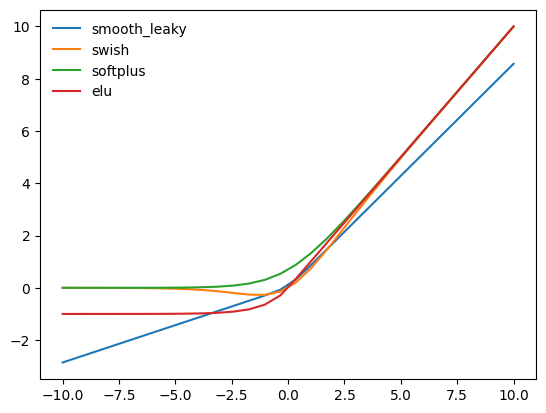

In [25]:
xfoo = jnp.linspace(-10, 10, 30)
plt.plot(xfoo, smooth_leaky(xfoo), label='smooth_leaky')
plt.plot(xfoo, nn.swish(xfoo), label='swish')
plt.plot(xfoo, nn.softplus(xfoo), label='softplus')
plt.plot(xfoo, nn.elu(xfoo), label='elu')
# plt.plot(xfoo, nn.sigmoid(xfoo))
# plt.plot(xfoo, nn.tanh(xfoo))
plt.legend(framealpha=0.0)
plt.show()

In [26]:
# initialise mpk model
model_key = jr.key(44)

embed_model = simpleCNN(
                filters=32,
                cls_compression=cls_compression,
                act_cnn=nn.relu,
                act_dense=smooth_leaky,
                n_extra=4,
                dtype=jnp.float32,
)

In [27]:
%xmode context

Exception reporting mode: Context


In [28]:
wembed = embed_model.init(model_key, {"kappa": jnp.ones((512,512,8)),
                                      "cls": jnp.ones((10,2,4,28))
                                     }
                                      )

#outs,bed = embed_model.apply(wembed, jnp.ones((512,512,8)))

#outs.shape

In [29]:
sum(x.size for x in jax.tree_util.tree_leaves(wembed))

70529

In [30]:
data = next(iter(train_dataset))

In [31]:
appl = lambda d: embed_model.apply(wembed, d, return_embed=True)

outs,xembed = jax.vmap(appl)(data['y'])

outs.shape, xembed.shape

((64, 14), (64, 4))

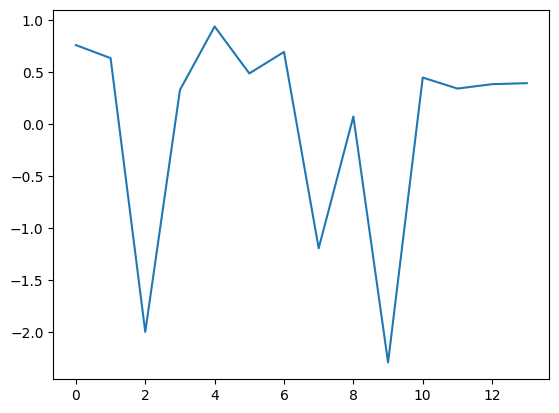

In [32]:
plt.plot(outs[33, :])
plt.show()

# build EPE model
this model combines the embedding network an MDN to calculate the `-log_prob` loss method

In [33]:
from network.new_epe_code import *

class fullModel(EPEModel, nn.Module):
    n_extra: int
    n_params: int = 3
    n_components: int = 4

    def setup(self):
        self.mdn = MDN(
                        hidden_channels=[100],
                        n_components=self.n_components,
                        n_dimension=self.n_params,
                        act=nn.relu)
        
        self.embeding_net = simpleCNN(
                        filters=32,
                        cls_compression=cls_compression,
                        act_cnn=nn.relu,
                        act_dense=smooth_leaky,
                        n_extra=self.n_extra,
                        dtype=jnp.float32)

    def get_embed(self, x):
        return self.embeding_net(x)

    def log_prob(self, x, y):
        x = self.embeding_net(x)
        return self.mdn(x, y) 
    
    def __call__(self, x, y):
        x = self.embeding_net(x)
        return self.mdn(x, y)

In [34]:
model = fullModel(n_extra=4, n_params=3, n_components=4)

wfull = model.init(model_key, {"kappa": jnp.ones((512,512,8)),
                                      "cls": jnp.ones((10,2,4,28))
                                     }, jnp.ones((3,)), method=model.log_prob
                                      )

In [35]:
sum(x.size for x in jax.tree_util.tree_leaves(wfull))

74857

# train network with EPE minimiser module

In [ ]:
# instatiate minimiser code
epe_minimiser = EPE_minimiser(density_estimator=model)



# Clip gradients at max value, and evt. apply weight decay
transf = [optax.clip(2.0)]
# transf.append(optax.add_decayed_weights(1e-4))
optimizer = optax.chain(
    *transf,
    optax.adam(learning_rate=5e-5)
)
epochs = 400

w, losses = epe_minimiser.fit(jr.PRNGKey(2), data=None, 
                      batch_size=64,
                      n_iter=epochs,
                      n_early_stopping_patience=20,  #20
                      train_dataset=train_dataset,
                      val_dataset=test_dataset,
                      optimizer=optimizer,
                      outdir="/data103/makinen/des_results/patch_nets/net-A-new/",
                    )

  0%|          | 0/400 [00:00<?, ?it/s]2025-02-05 00:09:08.540483: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=1,k4=2,k5=1,k6=0,k7=0,k19=0} for conv (f32[64,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,8,512,512]{3,2,1,0}, f32[32,8,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-02-05 00:09:09.387939: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.84759472s
Trying algorithm eng20{k2=1,k4=2,k5=1,k6=0,k7=0,k19=0} for conv (f32[64,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,8,512,512]{3,2,1,0}, f32[32,8,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=

In [41]:
# save model weights
#save_obj(w, "/home/makinen/repositories/des-hybrid/vanilla-comparison/w" + postfix)

In [42]:
#np.save("/home/makinen/repositories/des-hybrid/vanilla-comparison/history" + postfix, losses)

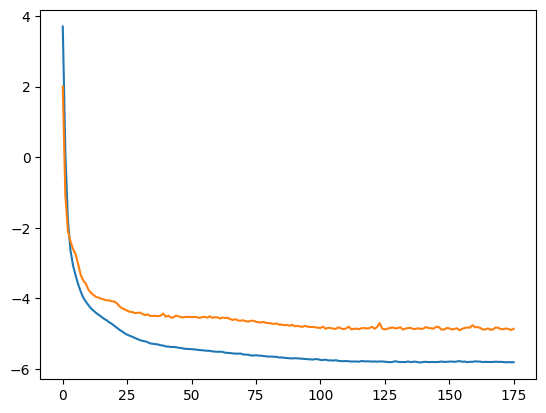

In [103]:
plt.plot(losses)
plt.show()

# get summaries

In [108]:
w_trained = w

In [114]:
def apply_embedding(input_data, w=w_trained):
    fn = lambda d: model.apply(w, x=d, method=model.get_embed)
    return jax.vmap(fn)(input_data)

In [115]:
train_dataset2 = get_tfdataset(train_files, BATCH_SIZE, scale_params=False, to_numpy=True)

test_dataset2 = get_tfdataset(test_files, BATCH_SIZE, scale_params=False, to_numpy=True)

lfi_dataset = get_tfdataset(lfi_files, BATCH_SIZE, scale_params=False, to_numpy=True, epochs=5, drop_remainder=False)
sys_dataset = get_tfdataset(test_sys_files, BATCH_SIZE, scale_params=False, to_numpy=True, epochs=5, drop_remainder=False)


num files:  12352
num files:  3088
num files:  3088
num files:  3088


In [116]:
# now apply to the lfi dataset as in Josh's code

summaries_LFI = []
params_Tru_LFI = []

for i in tqdm(range(lfi_dataset.num_batch_per_epoch)):

    data = next(iter(lfi_dataset))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_LFI.append(theta_true)
    summaries_LFI.append(summs_out)


summaries_test = []
params_Tru_test = []

for i in tqdm(range(test_dataset2.num_batch_per_epoch)):

    data = next(iter(test_dataset2))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_test.append(theta_true)
    summaries_test.append(summs_out)


summaries_sys = []
params_Tru_sys = []

for i in tqdm(range(sys_dataset.num_batch_per_epoch)):

    data = next(iter(sys_dataset))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_sys.append(theta_true)
    summaries_sys.append(summs_out)


summaries_train = []
params_Tru_train = []

for i in tqdm(range(train_dataset2.num_batch_per_epoch)):

    data = next(iter(train_dataset2))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_train.append(theta_true)
    summaries_train.append(summs_out)





summaries_LFI = np.concatenate(summaries_LFI, 0)
params_Tru_LFI = np.concatenate(params_Tru_LFI, 0)

summaries_test = np.concatenate(summaries_test, 0)
params_Tru_test = np.concatenate(params_Tru_test, 0)

summaries_sys = np.concatenate(summaries_sys, 0)
params_Tru_sys = np.concatenate(params_Tru_sys, 0)

summaries_train = np.concatenate(summaries_train, 0)
params_Tru_train = np.concatenate(params_Tru_train, 0)


100%|██████████| 193/193 [06:22<00:00,  1.98s/it]


In [117]:
np.savez("/home/makinen/repositories/des-hybrid/vanilla-comparison/summaries_A_new",
         summaries_lfi=summaries_LFI,
         params_lfi=params_Tru_LFI,
         summaries_test=summaries_test,
         params_test=params_Tru_test,
         summaries_sys=summaries_sys,
         params_sys=params_Tru_sys,
         summaries_train=summaries_train,
         params_train=params_Tru_train
         )

In [127]:
summaries_LFI.shape

(3072, 7)

In [120]:
normed_summs = (summaries_LFI - summaries_LFI.mean(0)) / summaries_LFI.std(0)

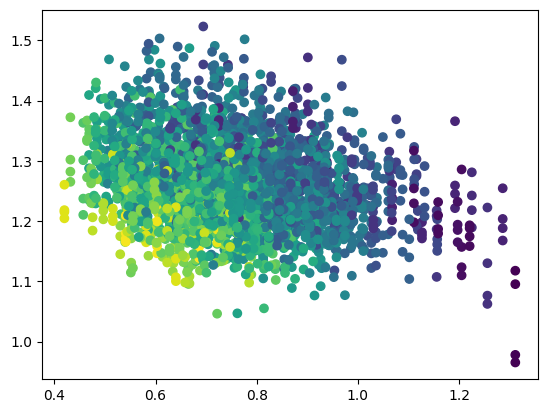

In [128]:
plt.scatter(params_Tru_LFI[:,1], summaries_LFI[:,-3], c=params_Tru_LFI[:, 0])
plt.show()
plt.close()

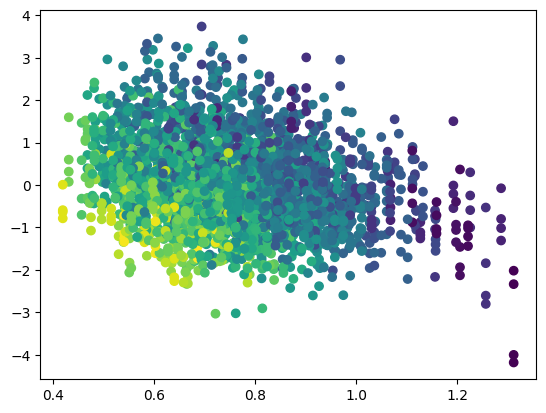

In [121]:
plt.scatter(params_Tru_LFI[:,1], normed_summs[:,-3], c=params_Tru_LFI[:, 0])
plt.show()
plt.close()

In [122]:
summaries_LFI.min()

-1.7568634

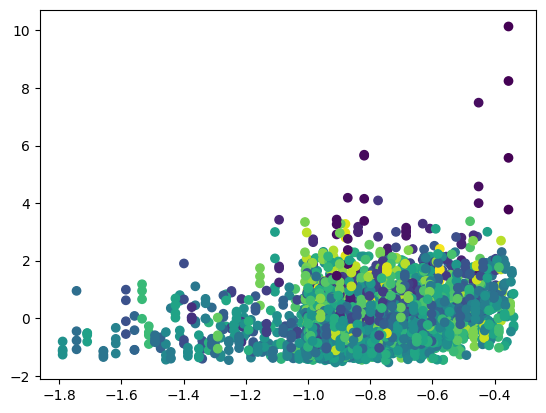

In [123]:
plt.scatter(params_Tru_LFI[:,2], normed_summs[:,-2], c=params_Tru_LFI[:, 0])
plt.show()
plt.close()

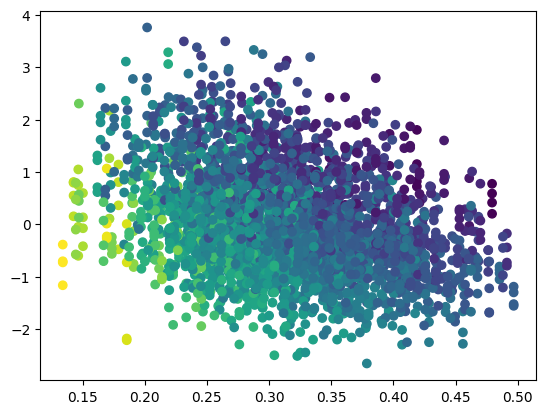

In [124]:
plt.scatter(params_Tru_LFI[:, 0], normed_summs[:, -1], c=params_Tru_LFI[:, 1])
plt.show()
plt.close()

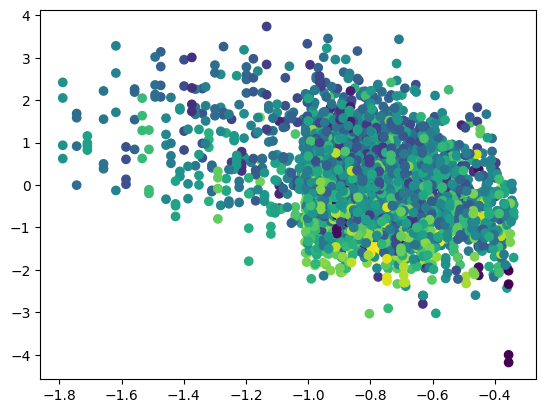

In [129]:
plt.scatter(params_Tru_LFI[:, 2], normed_summs[:, 4], c=params_Tru_LFI[:, 0])
plt.show()
plt.close()